https://www.tensorflow.org/datasets/catalog/colorectal_histology
https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/image_classification/colorectal_histology.py

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds


In [ ]:
dataset, info = tfds.load("colorectal_histology", with_info=True, as_supervised=True, shuffle_files=True)

In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/datasets/master/tensorflow_datasets/image_classification/colorectal_histology.py

--2024-05-19 20:54:45--  https://raw.githubusercontent.com/tensorflow/datasets/master/tensorflow_datasets/image_classification/colorectal_histology.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5400 (5.3K) [text/plain]
Saving to: ‘colorectal_histology.py.1’

colorectal_histolog 100%[===================>]   5.27K  --.-KB/s    in 0s      

2024-05-19 20:54:45 (77.8 MB/s) - ‘colorectal_histology.py.1’ saved [5400/5400]



In [ ]:
from colorectal_histology import _CLASS_NAMES
NUM_CLASSES = len(_CLASS_NAMES)
NAMES_CLASSES = _CLASS_NAMES

In [ ]:
NAMES_CLASSES

('tumor',
 'stroma',
 'complex',
 'lympho',
 'debris',
 'mucosa',
 'adipose',
 'empty')

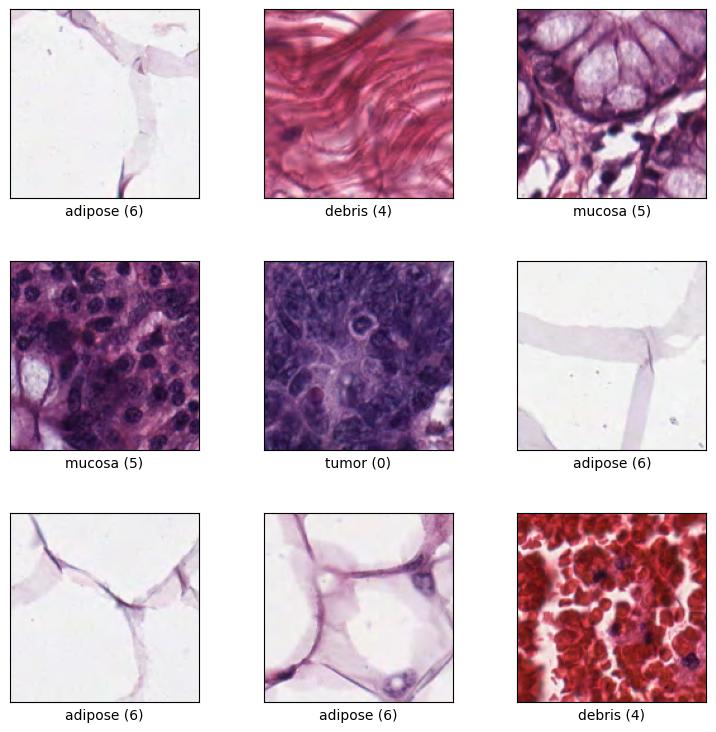

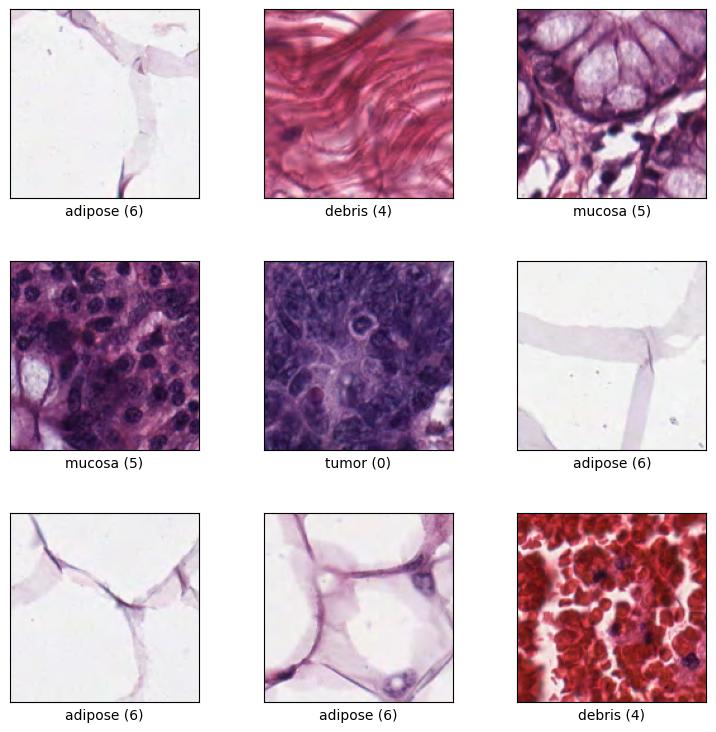

In [ ]:
dataset = dataset["train"]
tfds.show_examples(dataset, info)

In [ ]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
def make_train_valid_split(dataset, split = 0.2):

  dataset_size = len(dataset)
  train_split = int(dataset_size * (1 - split))
  valid_split = dataset_size - train_split

  train_set = dataset.take(train_split)
  valid_set = dataset.skip(train_split)

  return train_set, valid_set

In [ ]:
train_set, valid_set = make_train_valid_split(dataset)
len(train_set), len(valid_set)

(4000, 1000)

In [ ]:
BATCH_SIZE = 32
train_set = train_set.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
valid_set = valid_set.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

len(train_set), len(valid_set)

(125, 32)

In [ ]:
from tensorflow.keras import layers, Sequential

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])

In [ ]:

model = Sequential([
    # Primera capa de normalización
    layers.Rescaling(scale=1.0/255.0, input_shape=(150, 150, 3)),
    data_augmentation,
    layers.BatchNormalization(),
    # Primera capa de convolución y pool
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Segunda capa de convolución y pool
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Tercera capa de convolución y pool
    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Aplanamiento y capas densas
    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation="softmax")
], name="model_0")

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=100,
          validation_data=valid_set,
          validation_steps=len(valid_set),
          callbacks=[tf.keras.callbacks.ModelCheckpoint(model.name, save_best_only=True),
                     tf.keras.callbacks.EarlyStopping('val_loss', patience=20, restore_best_weights=True)]
          )

Epoch 1/100
125/125 [==============================] - 23s 160ms/step - loss: 1.4155 - accuracy: 0.3990 - val_loss: 1.9087 - val_accuracy: 0.2910
Epoch 2/100
125/125 [==============================] - 19s 153ms/step - loss: 1.0757 - accuracy: 0.5175 - val_loss: 1.0524 - val_accuracy: 0.5700
Epoch 3/100
125/125 [==============================] - 20s 156ms/step - loss: 0.9512 - accuracy: 0.5997 - val_loss: 0.7710 - val_accuracy: 0.7210
Epoch 4/100
125/125 [==============================] - 19s 150ms/step - loss: 0.8980 - accuracy: 0.6275 - val_loss: 0.6827 - val_accuracy: 0.7340
Epoch 5/100
125/125 [==============================] - 15s 121ms/step - loss: 0.8151 - accuracy: 0.6877 - val_loss: 0.6990 - val_accuracy: 0.7620
Epoch 6/100
125/125 [==============================] - 19s 154ms/step - loss: 0.7309 - accuracy: 0.7243 - val_loss: 0.6422 - val_accuracy: 0.7420
Epoch 7/100
125/125 [==============================] - 20s 159ms/step - loss: 0.7233 - accuracy: 0.7310 - val_loss: 0.5814 -

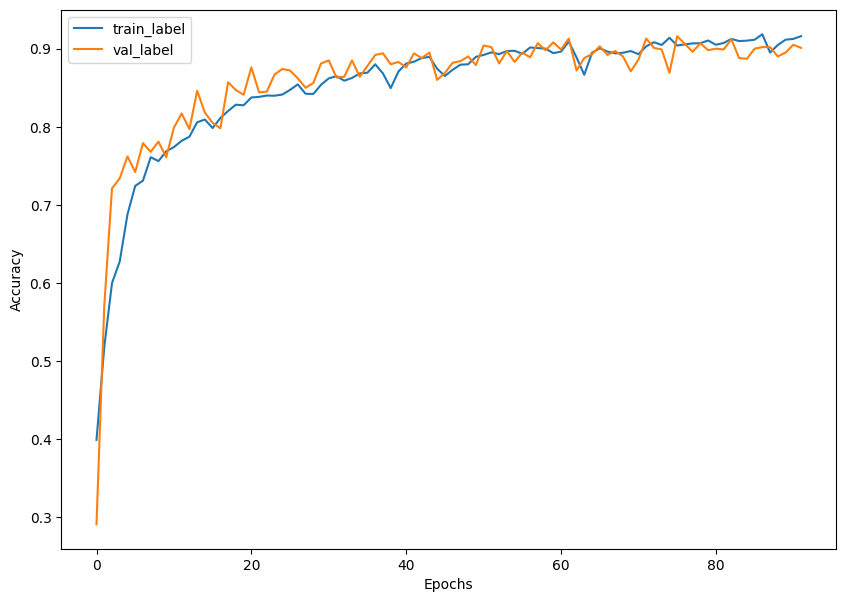

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.plot(history.history['accuracy'], label="train_label")
plt.plot(history.history["val_accuracy"], label="val_label")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

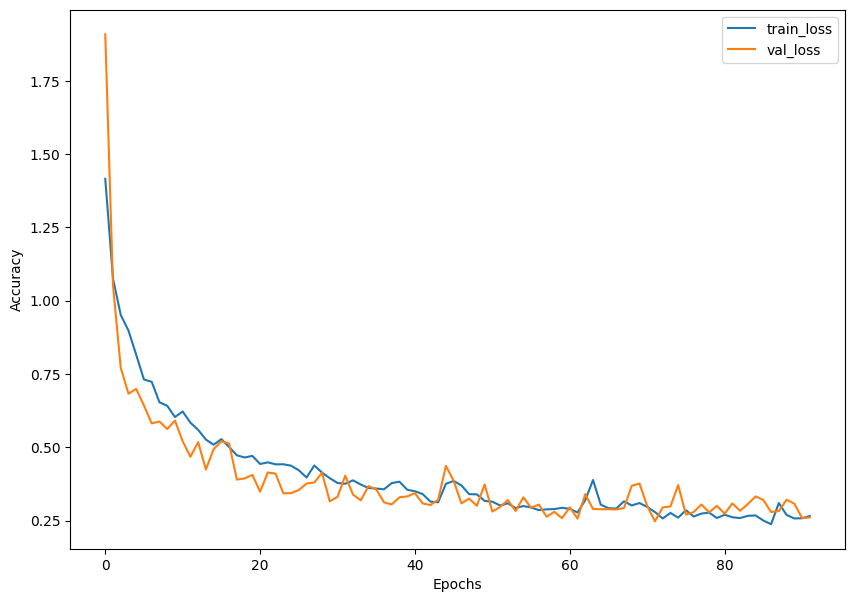

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
better_model = tf.keras.models.load_model("/content/model_0")

In [ ]:
test_loss, test_acc = better_model.evaluate(valid_set)
print(f"Accuracy: {test_acc*100}% ")

32/32 [==============================] - 4s 27ms/step - loss: 0.2474 - accuracy: 0.9130
Accuracy: 91.29999876022339% 
